# AI Stock Picking Platform

## 1. Get HK Stock form Google Finance

In [1]:
import os
import shutil

import gspread
import pandas as pd
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime as dtt
from datetime import date as dtd

TODAY = dtt.today()
CACHE_LIST = ['stock_hist','output']

def GetHKstockFromGoogleFinance():
    scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name('temp/GFcred.json',scope)
    client = gspread.authorize(creds)
    sheet = client.open('stocklist').sheet1
    df = pd.DataFrame(sheet.get_all_records())
    df = df.loc[df['tradetime'] == df['tradetime'].max()]
    df = df.replace(['#N/A'],0)
    # Change Data Type of 'tradetime' from object to datetime
    df['tradetime'] = pd.to_datetime(df['tradetime'],format='%Y/%m/%d')
    # Change Data Type of 'tradetime' from datetime to object
    # df['tradetime'] = df['tradetime'].dt.strftime('%Y/%m/%d')
    df = df.reset_index(drop=True)
    # df.to_csv('temp/stock_FA_GF.csv')
    # df = pd.read_csv('temp/stock_FA_GF.csv')
    return df

def clear_cache(caches):
    for c in caches:
        if os.path.exists(c):
            shutil.rmtree(c)
        os.makedirs(c)

clear_cache(CACHE_LIST)
df_fa = GetHKstockFromGoogleFinance()

In [2]:
from datetime import date as dtd
from  datetime  import  timedelta

# cdate = dtd(2020,2,29)
# Calculate the specific date of last year 
def last_date(y=1,m=0,d=0, date = TODAY):
    ly = date.year - y
    lym = date.month - m
    lyd = date.day - d
    if ly%4 !=0 and lym == 2 and lyd > 28:
        lyd = date.day - 1
    ld = dtd(ly,lym,lyd).isoformat()
    return ld

last_date(2)

'2019-03-07'

In [3]:
df_fa['tradetime']

0      2021-03-05
1      2021-03-05
2      2021-03-05
3      2021-03-05
4      2021-03-05
          ...    
1517   2021-03-05
1518   2021-03-05
1519   2021-03-05
1520   2021-03-05
1521   2021-03-05
Name: tradetime, Length: 1522, dtype: datetime64[ns]

## 2. Fundamental stock picking

In [4]:
# Simple Fundanmental Analyist Stock Screener 1 - SFASS1
# PE < 15，保證回本不會太慢
# EPS > 0.5, 確保股票有盈利
# changepct > 0，保證股價現在上升
def SFA_Screener_1(df):
    cod1 = df['pe'] < 15
    cod2 = df['eps'] > 0.5
    cod3 = df['changepct'] > 0
    df_FASS1 = df.loc[cod1 & cod2 & cod3].sort_values(by=['pe'], ascending=False)
    df_FASS1.to_csv('temp/FASS1.csv',index=False)
    return df_FASS1
df_FASS1 = SFA_Screener_1(df_fa)
df_FASS1

,id,Symbol,name,price,priceopen,high,low,volume,marketcap,tradetime,datadelay,volumeavg,pe,eps,high52,low52,change,changepct,closeyest,shares
1048,1651.HK,HKG:1651,Precision Tsugami China Corporation Ltd,9.08,8.61,9.10,8.61,39000,3457700290,2021-03-05,15,190402,14.19,0.64,9.31,5.33,0.37,4.25,8.71,380804000
604,0868.HK,HKG:0868,Xinyi Glass Holdings Ltd.,22.45,21.00,22.95,19.90,24206445,90699095207,2021-03-05,15,14010686,14.13,1.59,25.15,7.74,0.50,2.28,21.95,4040048647
1364,3306.HK,HKG:3306,JNBY Design Ltd,12.74,12.70,12.76,12.00,2099400,6608874881,2021-03-05,15,1088006,13.91,0.92,13.48,6.00,0.04,0.31,12.70,518750000
536,0763.HK,HKG:0763,ZTE Ord Shs H,20.90,20.00,20.90,19.96,9048016,164633100795,2021-03-05,15,13685322,13.71,1.52,34.80,16.50,0.35,1.70,20.55,755502534
719,1044.HK,HKG:1044,Hengan International Group Company Ltd,54.70,53.00,55.10,52.85,6810405,64892657615,2021-03-05,15,4456134,12.65,4.32,72.00,51.35,1.60,3.01,53.10,1186337417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0605.HK,HKG:0605,China Financial Services Holdings Ltd,1.98,1.91,1.98,1.89,123500,414386416,2021-03-05,15,27337,3.59,0.55,6.60,1.40,0.02,1.02,1.96,209286067
289,0390.HK,HKG:0390,China Railway Group Ord Shs H,4.15,4.03,4.17,4.00,48610286,162394691231,2021-03-05,15,35277110,3.36,1.24,4.85,3.33,0.08,1.97,4.07,4207390000
1410,3698.HK,HKG:3698,Huishang Bank Corp Ltd,2.65,2.63,2.67,2.60,106100,71867048586,2021-03-05,15,99011,2.75,0.96,2.99,2.49,0.02,0.76,2.63,3478750000
88,0113.HK,HKG:0113,Dickson Concepts (International) Ltd,4.08,4.01,4.08,3.86,249500,1608347426,2021-03-05,15,139315,2.44,1.67,4.70,2.95,0.01,0.25,4.07,394202808


In [5]:
print('Fundanmental Analyist Stock Screener 1 - FASS1')
print('pick the number of stocks: ' + str(len(df_FASS1.index)))
print('The csv result saved')

Fundanmental Analyist Stock Screener 1 - FASS1
pick the number of stocks: 65
The csv result saved


### 3 Stock Screen 2 (Technical analysis)

[Python量化交易 ](https://blog.csdn.net/m0_46603114/category_9820181_2.html)

关于如何选股，学术界提出过很多不同的模型，最经典的莫过于马科维茨投资组合理论。这里我们使用MM趋势模型(Mark Minervini’s Trend Template)，这是国外一位传奇投资大师提出的技术面选股方法，核心思想是通过技术指标来度量股票动能，从中筛选最有潜力的股票，买入并持有。

**MM趋势模型**  
* 股票价格高于150天均线和200天均线   
* 150日均线高于200日均线  
* 200日均线上升至少1个月  
* 50日均线高于150日均线和200日均线  
* 股票价格高于50日均线  
* 股票价格比52周低点高30%  
* 股票价格在52周高点的25%以内  
* 相对强弱指数(RS)大于等于70，这里的相对强弱指的是股票与大盘对比，RS = 股票1年收益率 / 基准指数1年收益率  

根据MM趋势模型，我们最少需要过去260天的历史数据，部分新上市或已退市的股票可能不符合要求，所以剔除K线数量少于260的股票。

    """实现MM选股模型的逻辑，评估单只股票是否满足筛选条件"""

    # 筛选条件1：收盘价高于150日均线和200日均线
    # 筛选条件2：150日均线高于200日均线
    # 筛选条件3：200日均线上升1个月
    # 筛选条件4：50日均线高于150日均线和200日均线
    # 筛选条件5：收盘价高于50日均线
    # 筛选条件6：收盘价比52周低点高30%
    # 筛选条件7：收盘价在52周高点的25%以内
    # 筛选条件8：相对强弱指数大于等于70
    # 判断股票是否符合标准

[Screen for Mark Minervini's Trend Template
](https://www.incrediblecharts.com/stock_screener/stock_screener-minervini-trend-template.php)

[How To Scan for Mark Minervini’s Trend Template in Think Or Swim](https://www.marcellagerwerf.com/mark-minervini-trend-template-thinkorswim-scan/)

In [6]:
import pandas_ta as ta
import pandas_datareader as pdr
import yfinance as yf

symbols = df_FASS1['id']
OUTPUT = {"symbol":"",
          "rsi":"",
          "close":"",
          "ema_50":"",
          "ema_150":"",
          "ema_200":"",
          "high_52week":"",
          "low_52week":"",
          "match":""
         }

# MMTT Technical Analyist Stock Screener 1 - TASS1
# PE < 15，保證回本不會太慢
# EPS > 0.5, 確保股票有盈利
# changepct > 0，保證股價現在上升
def MMTT_TA_Screener_1(close: pd.Series) -> pd.Series:
    # Calculate the EMA of 50, 150 and 200 days
    ema_50 = ta.ema(df.Close,length=50)[-1]
    ema_150 = ta.ema(df.Close,length=150)[-1]
    ema_200 = ta.ema(df.Close,length=200)
    
    # The 20-day moving smooth of the 200-day moving average is used to determine 
    # whether the 200-day moving average is rising
    ema_200_smooth  = ema_200.rolling(window=20).mean().iloc[-1]
    ema_200 = ema_200[-1]
    
    # 52-week high and 52-week low of the closing price
    high_52week = df.Close.rolling(52 * 5).max().iloc[-1]
    low_52week = df.Close.rolling(52 * 5).min().iloc[-1]
    
    # RSI
    rsi = ta.rsi(df.Close,length=20)[-1]
    
    # Latest closing price
    cl = df.Close.iloc[-1]
    
    # Condition 1: closing price > 150-day & 200-day EMA
    if cl > ema_150 and cl > ema_200:
        cod_1 = True
    else:
        cod_1 = False

    # Condition 2:  150-day EMA > 200-day EMA
    if ema_150 > ema_200:
        cod_2 = True
    else:
        cod_2 = False

    # Condition 3：200-day EMA rose by 1 month
    if ema_200 > ema_200_smooth:
        cod_3 = True
    else:
        cod_3 = False

    # Condition 4：50 EMA >150日 & 200EMA
    if ema_50 > ema_150 and ema_50 > ema_200:
        cod_4 = True
    else:
        cod_4 = False

    # Condition 5：Close price  > EMA
    if cl > ema_50:
        cod_5 = True
    else:
        cod_5 = False

    # Condition 6：Closing price is 30% above the 52-week low
    if cl >= low_52week * 1.3:
        cod_6 = True
    else:
        cod_6 = False

    # Condition 7：Closing price is within 25% of the 52-week high
    if cl >= high_52week * 0.75 and cl <= high_52week * 1.25:
        cod_7 = True
    else:
        cod_7 = False

    # Condition 8：RSI >= 70
    if rsi >= 70:
        cod_8 = True
    else:
        cod_8 = False

    # 判断股票是否符合标准
    if (cod_1 and cod_2 and cod_3 and
        cod_4 and cod_5 and cod_6 and
        cod_7 and cod_8):
        match = True
    else:
        match = False
    
    out = {
        "symbol":s,
        "rsi": round(rsi, 2),
        "close": cl,
        "ema_50": ema_50,
        "ema_150": ema_150,
        "ema_200": ema_200,
        "high_52week": high_52week,
        "low_52week": low_52week,
        "match": match
    }

    return pd.Series(out)

### Prepare the pd for download stock prices
df = pd.DataFrame()
df_TASS1 = pd.DataFrame(columns=OUTPUT)
failed_list = []

## Yfinance with pandas Download
yf.pdr_override() # <== that's all it takes :-)
for s in symbols:
    try:
        # print('processing: ' + s + ' ')
        # df = pdr.get_data_yahoo(s, start=start, end=end)
        df = pdr.get_data_yahoo(s)[-260:]
        df_TASS1 = df_TASS1.append(MMTT_TA_Screener_1(df.Close), ignore_index=True)
        df.to_csv('stock_hist/'+s+'.csv')
    except:
        failed_list.append(s)
        continue
df_TASS1

,symbol,rsi,close,ema_50,ema_150,ema_200,high_52week,low_52week,match
0,1651.HK,58.75,9.080000,8.388955,7.588915,7.317930,9.160000,5.500000,False
1,0868.HK,55.48,22.450001,20.883754,17.528461,15.924832,23.700001,8.150000,False
2,3306.HK,73.00,12.740000,10.158173,9.014159,8.631360,12.980000,6.130000,True
3,0763.HK,48.02,20.900000,21.253363,21.493697,22.084272,35.200001,16.920000,False
4,1044.HK,50.25,54.700001,54.798219,56.698622,58.060647,71.000000,52.099998,False
...,...,...,...,...,...,...,...,...,...
60,0605.HK,55.47,1.980000,1.910474,2.472397,2.841953,6.900000,1.450000,False
61,0390.HK,63.22,4.150000,3.808622,3.849741,3.928414,4.790000,3.340000,False
62,3698.HK,53.35,2.650000,2.609230,2.610480,2.632095,2.970000,2.520000,False
63,0113.HK,63.19,4.080000,3.847617,3.833533,3.915782,4.700000,3.100000,False


In [7]:
df_TASS1_match = df_TASS1.loc[df_TASS1['match'] == True].reset_index(drop=True)
df_TASS1_match

,symbol,rsi,close,ema_50,ema_150,ema_200,high_52week,low_52week,match
0,3306.HK,73.00,12.74,10.158173,9.014159,8.631360,12.98,6.13,True
1,2368.HK,78.60,4.88,4.216516,3.746040,3.470445,4.88,2.09,True
2,0746.HK,73.76,4.26,3.524785,3.310864,3.272773,4.26,2.83,True
3,0331.HK,85.90,5.00,3.801937,3.556644,3.484224,5.00,2.97,True
4,1238.HK,74.26,7.04,5.593104,5.391875,5.277875,7.04,4.03,True


In [8]:
print('Technical Analyist Stock Screener 1 - TASS1')
print('pick the number of stocks: ' + str(len(df_TASS1_match)))
print(df_TASS1_match['symbol'])
# print('The csv result saved')

Technical Analyist Stock Screener 1 - TASS1
pick the number of stocks: 5
0    3306.HK
1    2368.HK
2    0746.HK
3    0331.HK
4    1238.HK
Name: symbol, dtype: object


### 4 夏普比率分析股票的风险和回报
[什么是夏普比率？](https://zhuanlan.zhihu.com/p/61949367)

当你进行投资时，不仅只选择回报高的项目吗，還需要考慮综合考虑风险。
夏普比率(Sharpe Ratio)是由诺贝尔奖得主威廉·夏普提出的，用以帮助投资者比较投资的回报和风险。理性的投资者一般都是固定所能承受的风险，追求最大的回报；或者在固定预期回报，追去最小的风险。所以夏普比率计算的是，每承受一单位的总风险所产生的超额回报。计算公式如下：

$ Sharpe Ratio = \frac{R_p-R_f}{\sigma_p} $

$R_p$ 是预期回报率, $R_f$是无风险利率, $\sigma_p$是超额收益的标准差  
分子计算了差值说的是将某项投资与代表整个投资类别的基准进行比较，得到超额回报。分母标准差代表收益的波动率，对应着风险，因为波动越大预示着风险越高。

首先取得股票和恒生指數歷史價格
使用夏普比率来分析 已選取的股票，并将恒生指數做为比较的基准。

In [74]:
symbols = df_TASS1_match['symbol']
start = last_date(1) # today - 1 years
end = TODAY.strftime("%Y-%m-%d")

def PickedStocksAdjClose(symbols):
    df = pd.DataFrame()
    for s in symbols[:10]:
        df[s] = yf.download(s,start,end)['Adj Close']
    # for s in symbols[:10]:
    #     df[s] = pd.read_csv('stock_hist/'+s+'.csv')[['Date'],['Adj Close']
    # for s in symbols[:10]:
    #     df[s] = pdr.get_data_yahoo(s,start,end)
    return df

df = PickedStocksAdjClose(symbols)
df_HSI = yf.download('^HSI',start,end)['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [75]:
print(df.info())
print(df.head())
print(df_HSI.head())
print(df_HSI.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246 entries, 2020-03-09 to 2021-03-05
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   3306.HK  246 non-null    float64
 1   2368.HK  246 non-null    float64
 2   0746.HK  246 non-null    float64
 3   0331.HK  246 non-null    float64
 4   1238.HK  246 non-null    float64
dtypes: float64(5)
memory usage: 11.5 KB
None
             3306.HK   2368.HK   0746.HK   0331.HK   1238.HK
Date                                                        
2020-03-09  6.890819  2.403945  3.314178  3.490263  4.930548
2020-03-10  6.943488  2.449302  3.314178  3.469122  4.988782
2020-03-11  6.943488  2.512803  3.286249  3.517171  5.532307
2020-03-12  6.794260  2.512803  3.239702  3.373024  5.163487
2020-03-13  6.495804  2.267873  3.165226  3.305756  5.066429
Date
2020-03-09    25040.460938
2020-03-10    25392.509766
2020-03-11    25231.609375
2020-03-12    24309.070312
2020-03-13    24032.91015

In [76]:
print(df.describe())
print(df_HSI.describe())

          3306.HK     2368.HK     0746.HK     0331.HK     1238.HK
count  246.000000  246.000000  246.000000  246.000000  246.000000
mean     7.589316    3.042392    3.099883    3.274454    5.119028
std      1.587471    0.846325    0.256521    0.317271    0.578384
min      5.380983    1.895941    2.759250    2.854098    3.911439
25%      6.436552    2.281480    2.921250    3.036683    4.590950
50%      6.943488    2.786911    3.001500    3.233683    5.161744
75%      8.800000    3.850000    3.277500    3.460000    5.531994
max     12.980000    4.880000    4.260000    5.000000    7.040000
count      246.000000
mean     25578.466543
std       2001.163179
min      21696.130859
25%      24300.567383
50%      24935.155273
75%      26458.101562
max      31084.939453
Name: Adj Close, dtype: float64


#### 4.1 股票回报率

要计算夏普比率，首先要知道股票的回报率，即当天股价减去前一天股价，得到的差值与前一天股价的比值。这里使用的是历史数据

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt

<module 'matplotlib.pyplot' from '/Users/lamtakloong/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

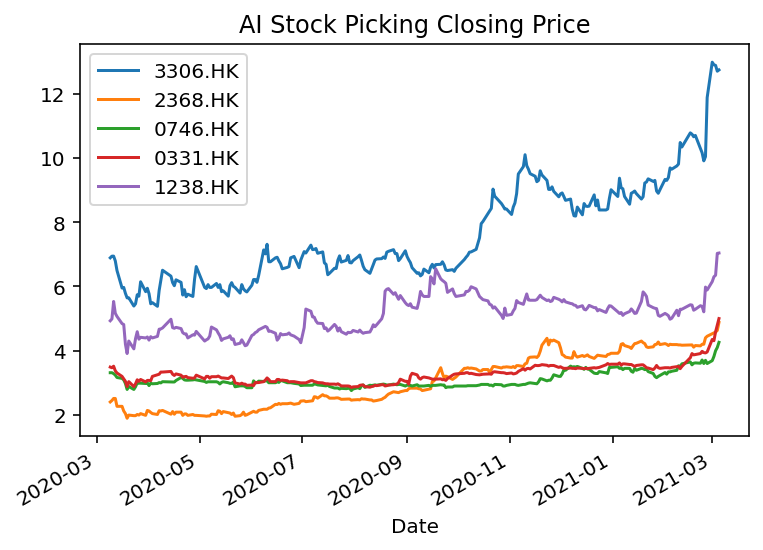

In [78]:
df.plot(title="AI Stock Picking Closing Price")
plt.savefig('output/img01.jpg')

          3306.HK     2368.HK     0746.HK     0331.HK     1238.HK
count  245.000000  245.000000  245.000000  245.000000  245.000000
mean     0.003024    0.003192    0.001162    0.001633    0.002007
std      0.032441    0.024504    0.016630    0.018322    0.033712
min     -0.098143   -0.097473   -0.062500   -0.053628   -0.127016
25%     -0.017199   -0.007937   -0.006667   -0.007332   -0.015254
50%      0.001228    0.000000    0.000000    0.000000   -0.001852
75%      0.018045    0.013699    0.006897    0.006024    0.012685
max      0.183267    0.100890    0.075342    0.098485    0.147793


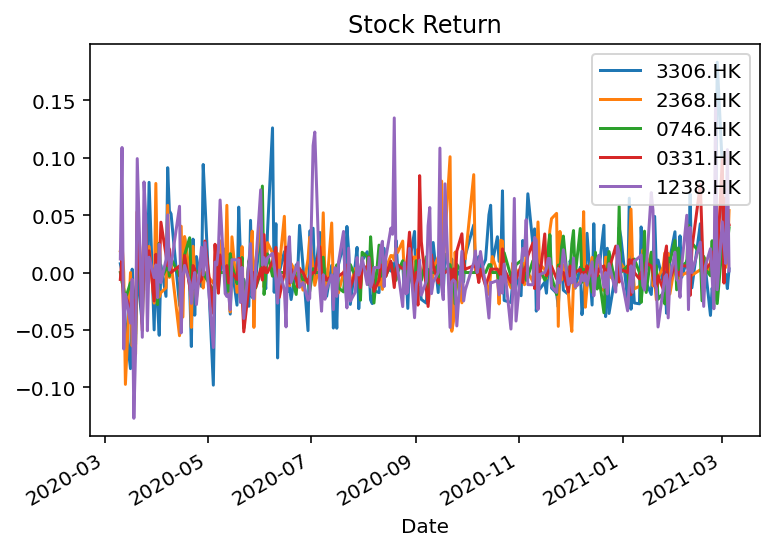

In [79]:
# 计算每日股票回报率
stock_returns = df.pct_change()
# 回报率绘图
stock_returns.plot(title='Stock Return')
plt.savefig('output/img02.jpg')
# 回报率统计量
print(stock_returns.describe())

#### 4.2恒生指数回报率

使用同样的方法，我们来查看恒生指数的回报率

count    245.000000
mean       0.000724
std        0.014895
min       -0.055597
25%       -0.006739
50%        0.001112
75%        0.009253
max        0.050483
Name: Adj Close, dtype: float64


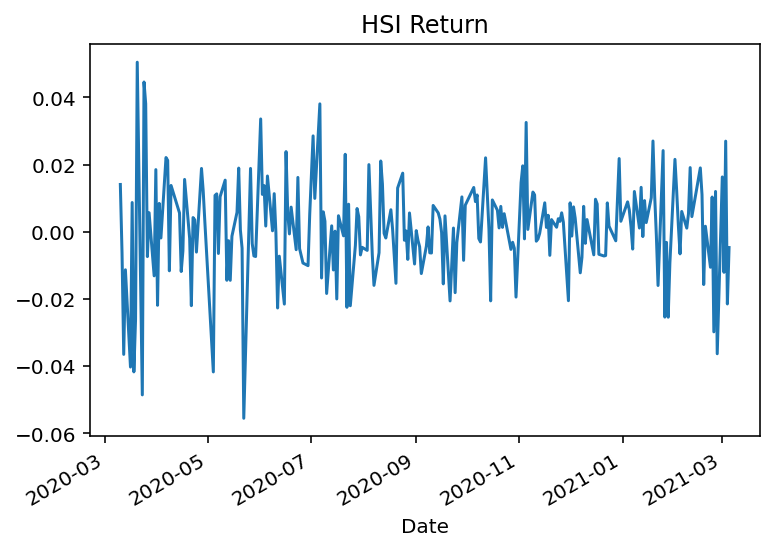

In [80]:
hsi_returns = df_HSI.pct_change()
hsi_returns.plot(title='HSI Return')
plt.savefig('output/img03.jpg')
print(hsi_returns.describe())

#### 4.3 每日超额回报

将股票收益和作为基准的恒生指数做比较，计算每日超额回报，即将股票回报率减去恒生指数的回报率。

          3306.HK     2368.HK     0746.HK     0331.HK     1238.HK
count  245.000000  245.000000  245.000000  245.000000  245.000000
mean     0.002300    0.002468    0.000438    0.000909    0.001283
std      0.030956    0.025951    0.017463    0.017868    0.029532
min     -0.063126   -0.086113   -0.042060   -0.039027   -0.085238
25%     -0.017130   -0.012295   -0.010489   -0.008875   -0.014021
50%      0.000582    0.001731   -0.000485   -0.001400   -0.003728
75%      0.015071    0.013808    0.008701    0.008357    0.010210
max      0.219642    0.121529    0.064243    0.088894    0.142155


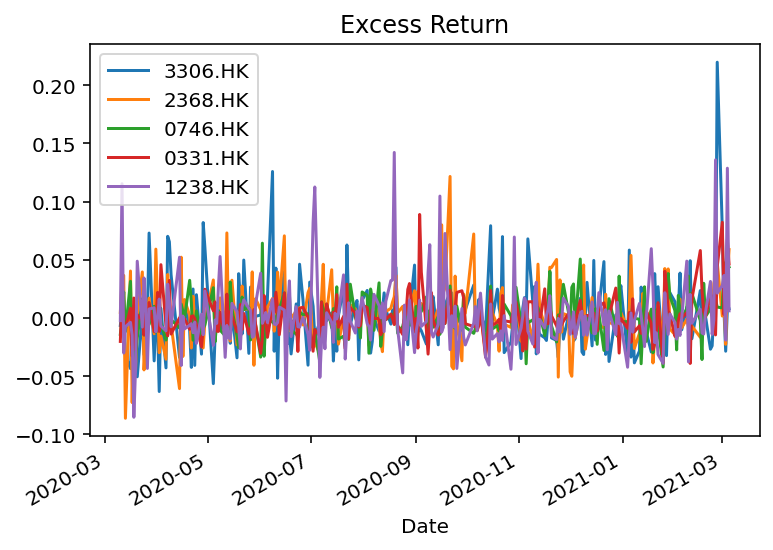

In [81]:
excess_returns = stock_returns.sub(hsi_returns, axis=0)  # 做减法

excess_returns.plot(title='Excess Return')
plt.savefig('output/img04.jpg')

print(excess_returns.describe())

#### 4.4 超额回报的均值

In [82]:
mean_excess_return = excess_returns.mean()
print(mean_excess_return)

3306.HK    0.002300
2368.HK    0.002468
0746.HK    0.000438
0331.HK    0.000909
1238.HK    0.001283
dtype: float64


<Figure size 432x288 with 0 Axes>

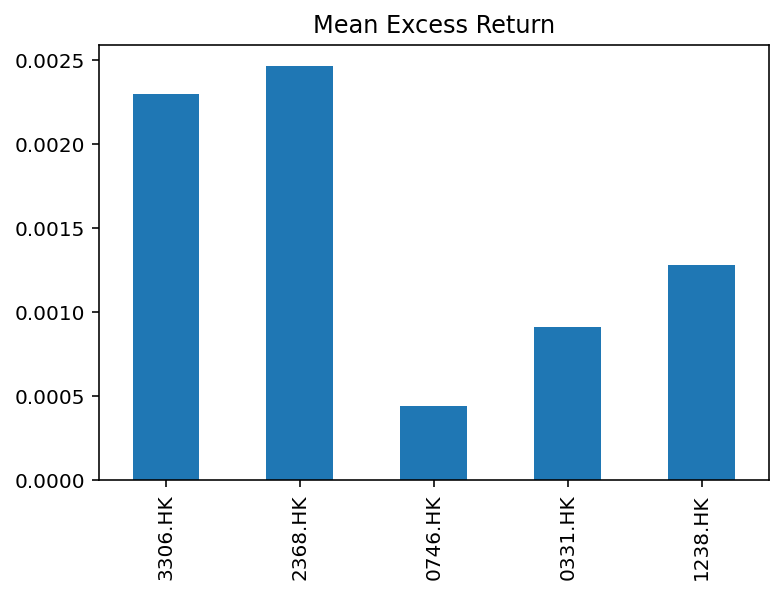

In [100]:
mean_excess_return.plot.bar(title='Mean Excess Return')
plt.savefig('output/img05.jpg')

#### 4.5 超额回报的标准差

In [104]:
# 计算标准差
sd_excess_return = excess_returns.std() 
print(sd_excess_return)

3306.HK    0.030956
2368.HK    0.025951
0746.HK    0.017463
0331.HK    0.017868
1238.HK    0.029532
dtype: float64


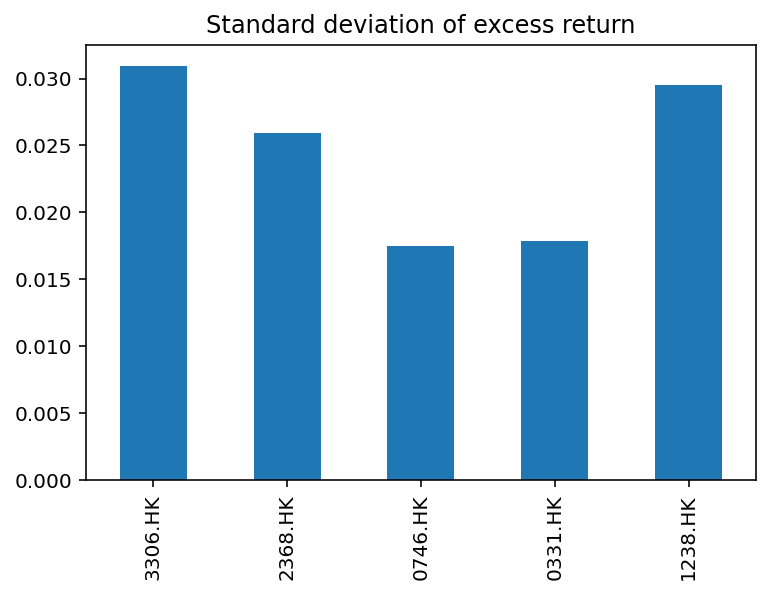

In [105]:
sd_excess_return.plot.bar(title='Standard deviation of excess return')
plt.savefig('output/img06.jpg')

#### 4.6 计算夏普比率

In [106]:
# 日夏普比率（.div 做除法）
daily_sharpe_ratio = mean_excess_return.div(sd_excess_return)
# 年化夏普比率（.mul 做乘法）
annual_factor = np.sqrt(252)
annual_sharpe_ratio = daily_sharpe_ratio.mul(annual_factor)
print(annual_sharpe_ratio)

3306.HK    1.179411
2368.HK    1.509443
0746.HK    0.398274
0331.HK    0.807271
1238.HK    0.689636
dtype: float64


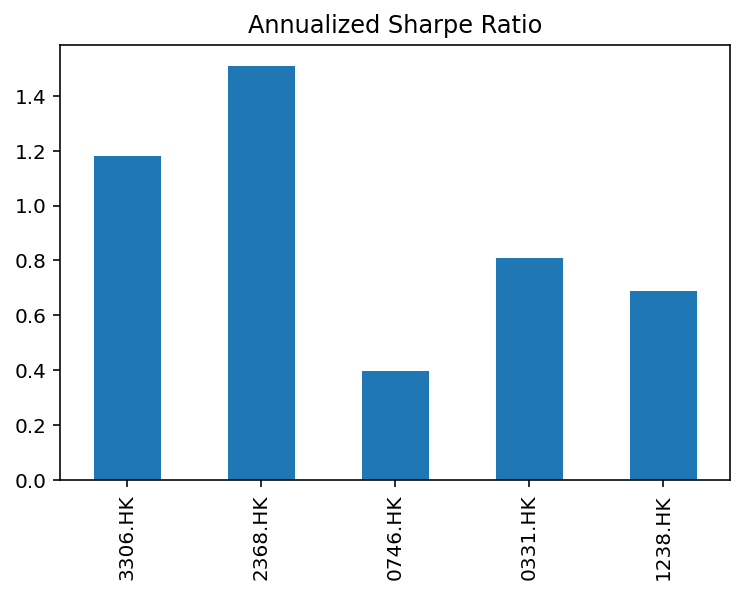

In [107]:
annual_sharpe_ratio.plot.bar(title='Annualized Sharpe Ratio')
plt.savefig('output/img07.jpg')

### 累積回報

## 5. Backtesting
[Moving Average Crossover Strategy](https://www.quantstart.com/articles/Backtesting-a-Moving-Average-Crossover-in-Python-with-pandas/)

In [131]:
from backtesting import Backtest, Strategy 
from backtesting.lib import crossover, resample_apply 
from backtesting.test import SMA 

# SimpleMovingAverageCrossover - Sma n1:, n2:
class SmaCross(Strategy): 
    n1 = 20
    n2 = 50

    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1) 
        self.sma2 = self.I(SMA, self.data.Close, self.n2) 

    def next(self):
        if crossover(self.sma1, self.sma2): 
            #如果周線衝上月線，表示近期是上漲的，則買入
            self.buy()
        elif crossover(self.sma2, self.sma1): 
            #如果周線再與月線交叉，表示開始下跌了，則賣出
            self.sell()

def SMA(array, n):
    """Simple moving average"""
    return pd.Series(array).rolling(n).mean()


def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    df = pd.Series(array)
    return ta.rsi(df,length=n)
#     gain = pd.Series(array).diff()
#     loss = gain.copy()
#     gain[gain < 0] = 0
#     loss[loss > 0] = 0
#     rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
#     return 100 - 100 / (1 + rs)
            
class RSIMA(Strategy):
    d_rsi = 30
    w_rsi = 30
    level = 70
    def init(self):
        self.ma10 = self.I(SMA, self.data.Close, 10)
        self.ma20 = self.I(SMA, self.data.Close, 20)
        self.ma50 = self.I(SMA, self.data.Close, 50)
        self.ma100 = self.I(SMA, self.data.Close, 100)
        
        self.daily_rsi = self.I(RSI, self.data.Close, self.d_rsi)
        
        self.weekly_rsi = resample_apply(
            'W-FRI', RSI, self.data.Close, self.w_rsi)

    def next(self):
        price = self.data.Close[-1]

        # If we don't already have a position, and
        # if all conditions are satisfied, enter long.
        if (not self.position and
            self.daily_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.daily_rsi[-1] and
            self.ma10[-1] > self.ma20[-1] > self.ma50[-1] > self.ma100[-1] and
            price > self.ma10[-1]):

            # Buy at market price on next open, but do
            # set 8% fixed stop loss.
            self.buy(sl=.92 * price)

        # If the price closes 2% or more below 10-day MA
        # close the position, if any.
        elif price < .98 * self.ma10[-1]:
            self.position.close()
            
            
            
            
# stock = "TSLA" #設定要測試的股票標的名稱
# df = pd.read_csv(f"data/{stock}.csv", index_col=0) 
#pandas讀取資料，並將第1欄作為索引欄
# df = df.interpolate() 
#CSV檔案中若有缺漏，會使用內插法自動補值，不一定需要的功能

In [132]:
s = symbols[0]
start = last_date(2)
end = last_date(0)
df = yf.download(s,start,end)
df.index = pd.to_datetime(df.index) #將索引欄資料轉換成pandas的時間格式，backtesting才有辦法排序

bt = Backtest(df, SmaCross, cash=100000, commission=.013)
result = bt.run()
bt.plot(filename=f"output/{s}_SmaCross.html") 

bt = Backtest(df, RSIMA, cash=100000, commission=.013)
result = bt.run()
bt.plot(filename=f"output/{s}_RSIMA2.html") 






# export result to df
str_btresult = str(result)
df_btresult = pd.DataFrame(result)


# bt.plot()
# test.plot(filename=f"./backtest_result/{stock}.html") 

# def BtSma(s,y=1,n1=5,n2=20,c1=100000,c2=0.013):
#     start = last_date(y)
#     end = last_date(0)
#     df = yf.download(s,start,end)
#     SmaCross.n1=n1
#     SmaCross.n2=n2
#     bt = Backtest(df, SmaCross, cash=c1, commission=c2)
#     print(bt.run())
#     bt.plot()



[*********************100%***********************]  1 of 1 completed


### 6. Save and send email

In [121]:
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.application import MIMEApplication#傳送附件
from email.mime.base import MIMEBase
from email import encoders
from pathlib import Path
from string import Template

# 基本電子郵件內容
msg = MIMEMultipart()  #建立MIMEMultipart物件
msg["subject"] = "FYP AI stock picking"  #郵件標題
msg["from"] = "takllam4@gmail.com"  #寄件者
msg["to"] = "lamtakloong@gmail.com" #收件者

# email content 
user='Sam'
pickstock=str(symbols.tolist())
stock_returns_html = stock_returns.describe().to_html()
hsi_returns_html = hsi_returns.describe().to_frame().to_html()
excess_returns_html = excess_returns.describe().to_html()
mean_excess_return_html = mean_excess_return.describe().to_frame().to_html()
sd_excess_return_html = sd_excess_return.to_frame().to_html()
annual_sharpe_ratio_html = annual_sharpe_ratio.to_frame().to_html()

msg_str = f"""
<p> <strong>{user}</strong>, the Ai stock picking send the recommendation to you today</p>
<p>If you can custom the setting, please login <a href="https://www.google.com/">here</a></p>
<p>The AI Picking stocks are : {pickstock}</p>
<table><tr><td>
<img src="cid:1">
<img src="cid:2"></td>
<td>{stock_returns_html}</td></tr>
<tr><td><img src="cid:3"></td>
    <td>{hsi_returns_html}</td></tr>
<tr><td><img src="cid:4"></td>
<td>{excess_returns_html}</td></tr>
<tr><td><img src="cid:5"></td>
<td>{mean_excess_return_html}</td></tr>
<tr><td><img src="cid:6"></td>
<td>{sd_excess_return_html}</td></tr>
<tr><td><img src="cid:7"></td>
<td>{annual_sharpe_ratio_html}</td></tr></table>
"""

msg.attach(MIMEText(msg_str, 'html', 'utf-8'))

pa = 'output/'
img = [_ for _ in os.listdir(pa) if _.endswith('.jpg')]
img.sort()

# add image in HTML format 
for i in range(len(img)):
    with open(pa+img[i],'rb') as f:
        img_data = f.read()
    msg_image = MIMEImage(img_data,'jpg')
    msg_image.add_header('Content-ID', '<%d>' % (i+1))
    # msg_image.add_header()
    msg.attach(msg_image)

htmlf = [_ for _ in os.listdir(pa) if _.endswith('.html')]

# add attachment 1
# html = open(pa+htmlf[0])
# part2 = MIMEText(html.read(), 'html')
# msg.attach(part2)

# add attachment 2
att = MIMEApplication(open(pa+htmlf[0],'rb').read())   #開啟附件
att.add_header('Content-Disposition','attachment',filename=htmlf[0]) #為附件命名
msg.attach(att)   #新增附件



# gmail application: ymwfmiovwxmhjcze
import smtplib
with smtplib.SMTP(host="smtp.gmail.com", port="587") as smtp:  # 設定SMTP伺服器
    try:
        smtp.ehlo()  # 驗證SMTP伺服器
        smtp.starttls()  # 建立加密傳輸
        smtp.login("takllam4@gmail.com", "ymwfmiovwxmhjcze")  # 登入寄件者gmail
        smtp.send_message(msg)  # 寄送郵件
        print("Complete!")
    except Exception as e:
        print("Error message: ", e)

Complete!


In [109]:
pa = 'output/'
img = os.listdir(pa)
img.sort()
len(img)
print(pa+img[0])

output/.ipynb_checkpoints


In [110]:
for i in range(len(img)):
    print(f'<{i+1}>')
    print(pa+img[i])

<1>
output/.ipynb_checkpoints
<2>
output/3306.HK.html
<3>
output/img01.jpg
<4>
output/img02.jpg
<5>
output/img03.jpg
<6>
output/img04.jpg
<7>
output/img05.jpg
<8>
output/img06.jpg
<9>
output/img07.jpg


In [111]:
img = [_ for _ in os.listdir(pa) if _.endswith('.jpg')]
img.sort()
len(img)

7

In [112]:
htmlf = [_ for _ in os.listdir(pa) if _.endswith('.html')]
htmlf

['3306.HK.html']